In [2]:
import cv2
# import pytesseract
import pandas as pd
import numpy as np
import segyio
from segyio import TraceField ,BinField
# import matplotlib.pyplot as plt
# from segpy.dataset import Dataset
import logging
from pathlib import Path
from scipy import signal
import toml
from PIL import Image, ImageOps
import datetime 
logger = logging.getLogger(__name__)
import os
from scipy.signal import butter, lfilter, freqz

from image2segy_utils import *

import matplotlib.pyplot as plt
%matplotlib inline
# datafolder=r'D:\Ameyem\Bhugarbho\JOGMEC\SeismicSection\Vietnam\\'
# crop_folder=datafolder+'cropped//'

# [f  for f in os.listdir(crop_folder) if '_crop' in f]

In [12]:
datafolder=r'D:\Ameyem\Bhugarbho\JOGMEC\SeismicSection\Vietnam\rawimages\\'
files=['0254_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ 74-730_crop.png',
      '0048_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-109_crop.png',
#        '0128_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ B-129_crop.png'
      ]

# files=['0254_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ 74-730_crop.jpg']

# viennadf=pd.read_excel(datafolder+'Data List from JOGMEC_June2022.xlsx','Vietnam', skiprows=[0])
file=files[-1]
key=2
timeranges={'103':[0,6],'108':[0,6],'109':[0,6],'111':[0,6],'116':[0,6],'117':[0,6],'119':[0,6],'0254':[0,5]}
filekey=file.split('_')[0]

fileproperties={'0254':{'strc':1114,'ntrace':1201,'trange':[0,5]},
                '0048':{'strc':1,'ntrace':3817,'trange':[0,6]},
                '0128':{'strc':1,'ntrace':3480,'trange':[0,6]},
}

ntrace=fileproperties[filekey]['ntrace']
ntrc=ntrace
strc=fileproperties[filekey]['strc']
etrc=strc+ntrc
stime,etime=np.array(fileproperties[filekey]['trange'])*1000
strc,etrc,ntrc,stime,etime

(1, 3818, 3817, 0, 6000)

In [13]:
# datafolder=r'D:\Ameyem\Bhugarbho\JOGMEC\SeismicSection\Vietnam\\'
# viennadf=pd.read_excel(datafolder+'Data List from JOGMEC_June2022.xlsx','Vietnam', skiprows=[0])
# viennadf

In [14]:
# datafolder=r'D:\Ameyem\Bhugarbho\JOGMEC\SeismicSection\Vietnam\cropped\cleaned\\'

# file='0045_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-103_crop.png'
image = cv2.imread(datafolder+file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

sgray=gray.sum(axis=1)

print(file,gray.shape)

0048_1974_South China Sea_2D_Repro_1974_Time_Unmigrated_ A-109_crop.png (4154, 29429)


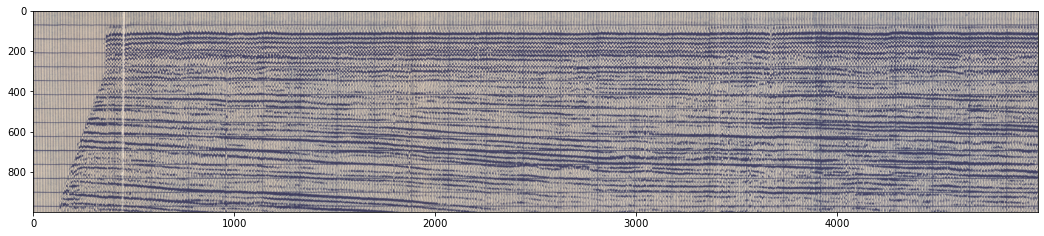

In [15]:
fig=plt.figure(figsize=(18,16))
plt.imshow(image[:1000,0:5000])
xlim=[0,3000]

In [ ]:
horizontal

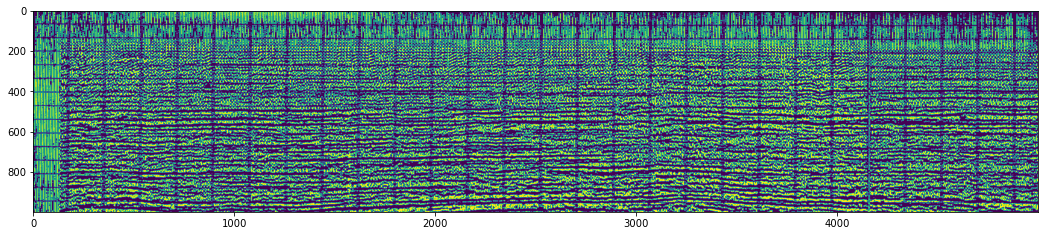

In [35]:
horizontal = cv2.adaptiveThreshold(gray[:1000,0:5000],255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,101,-2)
rows,cols = horizontal.shape
horizontalsize=5
#     print('horizontalsize',horizontalsize)
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize,1))
horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))

fig=plt.figure(figsize=(18,16))
plt.imshow(horizontal)
xlim=[0,3000]

In [36]:
# np.histogram(mthresh.ravel())
# image=mthresh/255.

# clipped_im=gray.copy()
# thresh=clipped_im.mean()
# clipped_im[clipped_im<=thresh]=1
# clipped_im[clipped_im>=thresh]=0
# clipped_im=precisionFiltering(clipped_im).astype(float)

In [16]:
def gethorizontalLineFilter(hf_data,sgray):
    hf_data[hf_data>0]=0
    hf_data[hf_data>-0.05]=0
    hf_data[hf_data<=-0.05]=1
    
    ids=np.where(hf_data==1)
    difids=np.diff(ids)
    difids[difids>1]
    spike_interval=int(np.median(difids[difids>1]))
    # ,np.mean(difids[difids>1])
    _,spikewidths=np.where(difids>1)
    spikewidth=int(np.median(np.diff(spikewidths)))
#     spike_interval,spikewidth
    halfspikew=int(spikewidth/2)
    x = np.arange(-halfspikew+1, 1,1)
    mfilter=x**2/40+0.01
    if len(mfilter)*2==spikewidth:
        mfilter=np.array([*mfilter,*mfilter[::-1]])
    else:
        mfilter=np.array([*mfilter,mfilter[-1],*mfilter[::-1]])
    smallfilter=np.append([1]*spike_interval,mfilter)
    times=int(len(sgray)/len(smallfilter))
    fullfilter=np.array([*smallfilter]*(times+1))[:len(sgray)]
    return fullfilter
def img2rawtrace(mthresh,stime,etime,ntrc): #key function need filters before
    thresh=mthresh.copy()
    trange=np.arange(stime,etime+1,2).astype(int)
    pixper_trc=thresh.shape[1]/ntrc
    halfpixper_trc=int(pixper_trc/2)
    print('ntrc,thresh.shape,pixper_trc ',ntrc,thresh.shape,pixper_trc)

    pixrange=np.arange(halfpixper_trc,thresh.shape[1]-halfpixper_trc,pixper_trc).astype(int)
    # # 
    # thresh[thresh<100]=0
    # thresh[thresh>100]=1
    
    tmean=thresh.mean()
    if tmean>100:
        tmean=100
    
    thresh[thresh<tmean]=0
    thresh[thresh>tmean]=1
    # plt.hist(thresh)

    traces=[]
    for i in range(len(pixrange)-1):
    #     print(pixrange[i],pixrange[i+1])
        trc=pixper_trc*thresh[:,pixrange[i]-halfpixper_trc:pixrange[i+1]+halfpixper_trc].sum(axis=1)/(pixrange[i+1]-pixrange[i]+pixper_trc)
        nlesThalf=np.sum(trc<=pixper_trc/2)
        ngreThalf=np.sum(trc>pixper_trc/2)
        if ngreThalf/nlesThalf<0.01:
            trc[trc<=pixper_trc/2]=trc[trc<=pixper_trc/2]*0.3
#     print(nlesThalf,ngreThalf,ngreThalf/nlesThalf)
    
        traces.append(trc)
    traces=np.array(traces).astype(float)
    return traces

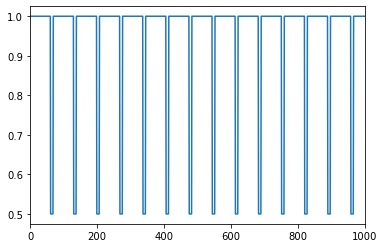

In [38]:
# hlfilter=gethorizontalLineFilter(hf_data)
# plt.plot(sgray)
twt=list(range(len(sgray)))
lf_data,wf_data,hf_data,xmaxnormmeans=windowFilt(twt,sgray,nclip=0,window=(1,10),order=4)

# useStepOp
hlfilter=gethorizontalLineFilter(hf_data,sgray)
hlfilter[hlfilter<=0.5]=0.5
plt.plot(hlfilter)
plt.xlim([0,1000])
plt.show()

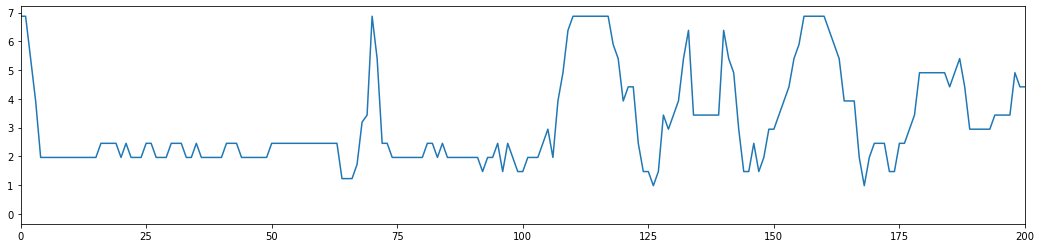

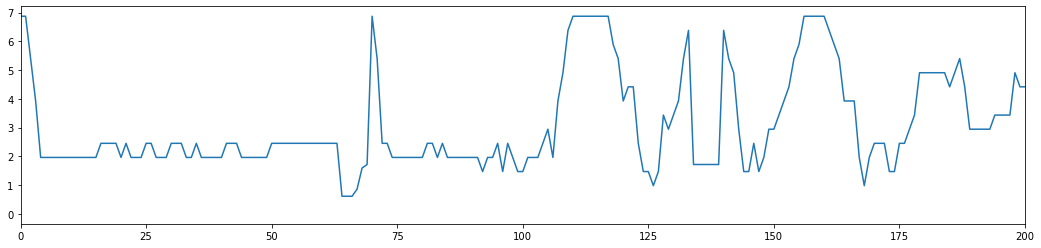

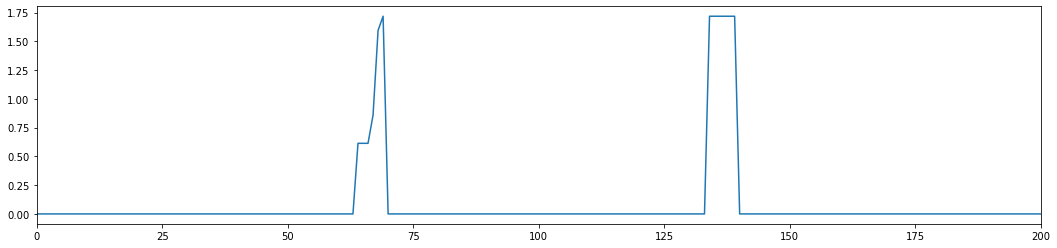

In [27]:
fig=plt.figure(figsize=(18,4))
xlim=[0,200]
plt.plot(mtrc)
plt.xlim(xlim)
plt.show()
hmtrc=mtrc*hlfilter
fig=plt.figure(figsize=(18,4))
plt.plot(hmtrc)
plt.xlim(xlim)
plt.show()

fig=plt.figure(figsize=(18,4))
plt.plot(mtrc-hmtrc)
plt.xlim(xlim)
plt.show()

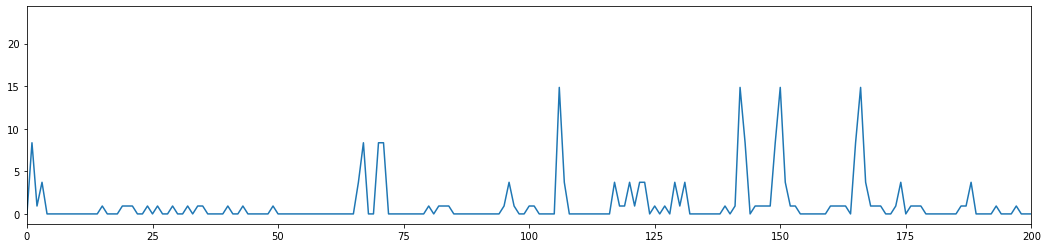

In [36]:
diff=np.diff(mtrc)
fig=plt.figure(figsize=(18,4))
plt.plot(diff**2)
plt.xlim([0,200])
plt.show()

In [34]:
def img2rawtrace(mthresh,stime,etime,ntrc): #key function need filters before
    thresh=mthresh.copy()
    trange=np.arange(stime,etime+1,2).astype(int)
    pixper_trc=thresh.shape[1]/ntrc
    print('ntrc,thresh.shape,pixper_trc ',ntrc,thresh.shape,pixper_trc)

    pixrange=np.arange(0,thresh.shape[1]+1,pixper_trc).astype(int)
    # # 
    # thresh[thresh<100]=0
    # thresh[thresh>100]=1
    
    tmean=thresh.mean()
    if tmean>100:
        tmean=100
    
    thresh[thresh<tmean]=0
    thresh[thresh>tmean]=1
    # plt.hist(thresh)

    traces=[]
    for i in range(len(pixrange)-1):
    #     print(pixrange[i],pixrange[i+1])
        trc=pixper_trc*thresh[:,pixrange[i]:pixrange[i+1]].sum(axis=1)/(pixrange[i+1]-pixrange[i])
        nlesThalf=np.sum(trc<=pixper_trc/2)
        ngreThalf=np.sum(trc>pixper_trc/2)
        if ngreThalf/nlesThalf<0.01:
            trc[trc<=pixper_trc/2]=trc[trc<=pixper_trc/2]*0.3
#     print(nlesThalf,ngreThalf,ngreThalf/nlesThalf)
    
        traces.append(trc)
    traces=np.array(traces).astype(float)
    return traces

In [33]:
# plt.hist(mthresh.ravel())

In [35]:
# bestcases={1:1,2:3,3:6}
sgray=gray.sum(axis=1)
cutoff = 30.0
bestcases={'_horlf':6}


mthresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

traces=img2rawtrace(mthresh,stime,etime,ntrc)
#     traces=successiveDeduction(traces,ntraces=200)
trcno=200
mtrc=traces[trcno]


# if useHorfilter:
#     mtrc=mtrc*hlfilter

# if not useStepOp:
#     op=getOperator(mtrc,old=False)
# else:
#     op=getOperatorStep(mtrc)


# # Filter or not and make resultant traces as float64 type
# tracet=traces.shape[1]
# actualt=etime
# tracetpermsec=tracet/etime
# for50msec=tracetpermsec*30
# traces[:,:int(for50msec)]=traces[:,:int(for50msec)]*0.1

# if useHorfilter:
#     result=(np.array(traces)*hlfilter*1000).astype(np.float64)
# else:
#     result=(np.array(traces)*1000).astype(np.float64)

# print(traces.shape,result.shape)
# trange=np.arange(stime,etime+1,2).astype(int)
# proctrcs= getOpProcTraces(result,op,trange)
# #     filttrcs=np.array(proctrcs)
# filttrcs= getLowPassfilteredTraces(proctrcs,cutoff = cutoff )



# inputdict=dict(dstpath=datafolder+file.replace('_crop.png','')+'_raw{}.sgy'.format(key),srcpath='bak_test2.sgy',
#            mintime=1300,mxtime=1500,dt=1,iline=1, xline=169, offset=0)

# status=saveAsSegy(filttrcs.T,inputdict=inputdict,delrt=2,strc=strc,setimes=[stime,etime])
# if status:    
#     print('Done export..',inputdict['dstpath'])
# else:
#     print('Export incomplete..')
# fig=plt.figure(figsize=(16,16))
# #     plt.imshow(filttrcs.T[:800,-800:])
# plt.imshow(filttrcs.T)
# plt.show()

ntrc,thresh.shape,pixper_trc  3817 (4154, 29429) 7.709981660990307


Case:  6
hlfilter
ntrc,thresh.shape,pixper_trc  3817 (4154, 29429) 7.709981660990307
0.0 :  nan
0.24538480780455266 :  0.0
0.4907696156091053 :  0.8518518518518519
0.7361544234136579 :  0.625
0.9815392312182106 :  1.0606060606060606
1.2269240390227634 :  0.43478260869565216
1.4723088468273158 :  0.9458333333333333
1.7176936546318686 :  0.3333333333333333
1.9630784624364213 :  1.1891891891891893
2.208463270240974 :  0.5384615384615384
2.4538480780455267 :  0.5993150684931506
2.6992328858500794 :  1.1111111111111112
2.9446176936546316 :  0.5
3.1900025014591846 :  0.0
3.4353873092637373 :  0.7672955974842768
3.9261569248728425 :  0.6074074074074074
4.416926540481948 :  0.4537037037037037
4.9076961560910535 :  0.4095238095238095
5.398465771700159 :  0.77
5.889235387309263 :  0.6818181818181818
6.380005002918369 :  0.4084507042253521
6.8707746185274745 :  4.465116279069767
signal_len  0.032
32
(3816, 4154) (3816, 4154)
(3001, 3816)
Reday to go
3816
Done export.. D:\Ameyem\Bhugarbho\JOGMEC\S

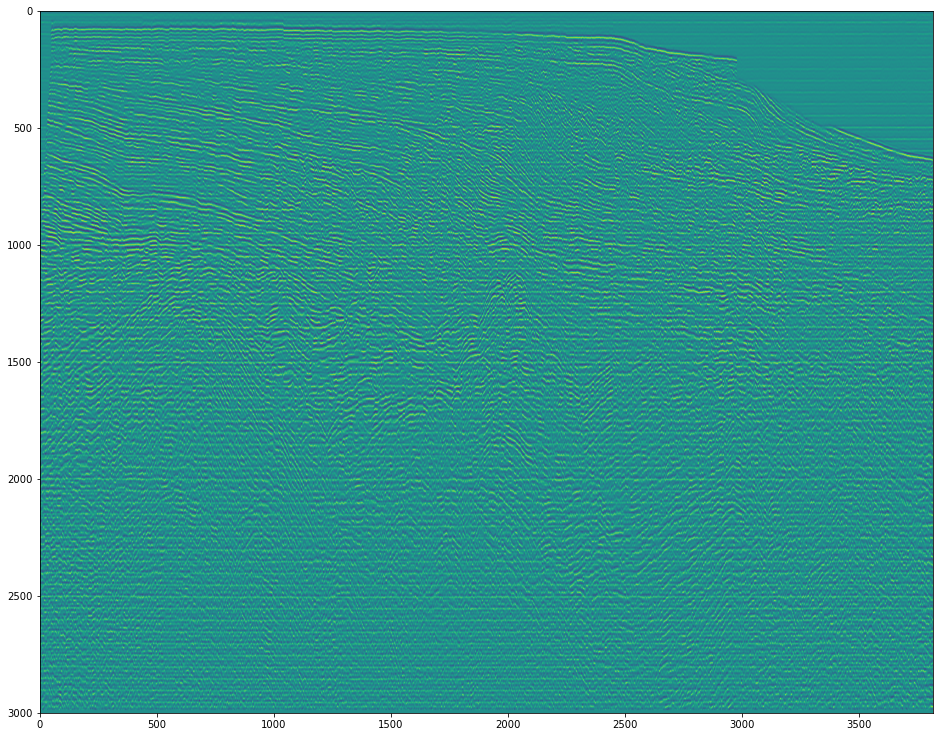

In [20]:
# bestcases={1:1,2:3,3:6}
sgray=gray.sum(axis=1)
cutoff = 30.0
bestcases={'_horlf':6}
for key in bestcases:
    case=bestcases[key]

# for case in range(1,7):
    print('Case: ',case)
    crude_hor_filter,useStepOp,useHorfilter=getDirections(case)
    #Horizontal filter calculation to remove horizontal lines
    twt=list(range(len(sgray)))
    lf_data,wf_data,hf_data,xmaxnormmeans=windowFilt(twt,sgray,nclip=0,window=(1,10),order=4)
    useHorfilter=True
    crude_hor_filter=False
    if useHorfilter:
        if not crude_hor_filter:
            hlfilter=gethorizontalLineFilter(hf_data,gray) #median gap found and kept lo values to nullify horizontal line
            hlfilter[hlfilter<=0.5]=0.5
            print('hlfilter')
        else:
            hlfilter=getHorizontalRawFilter(hf_data) #filter generate with crude way, line gaps are filled with 0.1 values

    mthresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    #     traces=img2rawtrace(clipped_im,stime,etime,ntrc)
    traces=img2rawtrace(mthresh,stime,etime,ntrc)
#     traces=successiveDeduction(traces,ntraces=200)

    # fig=plt.figure(figsize=(18,16))
    # plt.imshow(traces.T)


    # plt.plot(traces[:,int(for50msec)])

    #Operator for smooth trace
    trcno=200
    mtrc=traces[trcno]
    
    
    if useHorfilter:
        mtrc=mtrc*hlfilter
    
    if not useStepOp:
        op=getOperator(mtrc,old=False)
    else:
        op=getOperatorStep(mtrc)
        

    # Filter or not and make resultant traces as float64 type
    tracet=traces.shape[1]
    actualt=etime
    tracetpermsec=tracet/etime
    for50msec=tracetpermsec*30
    traces[:,:int(for50msec)]=traces[:,:int(for50msec)]*0.1
    
    if useHorfilter:
        result=(np.array(traces)*hlfilter*1000).astype(np.float64)
    else:
        result=(np.array(traces)*1000).astype(np.float64)

    print(traces.shape,result.shape)
    trange=np.arange(stime,etime+1,2).astype(int)
    proctrcs= getOpProcTraces(result,op,trange)
#     filttrcs=np.array(proctrcs)
    filttrcs= getLowPassfilteredTraces(proctrcs,cutoff = cutoff )
    

    
    inputdict=dict(dstpath=datafolder+file.replace('_crop.png','')+'_raw{}.sgy'.format(key),srcpath='bak_test2.sgy',
               mintime=1300,mxtime=1500,dt=1,iline=1, xline=169, offset=0)

    status=saveAsSegy(filttrcs.T,inputdict=inputdict,delrt=2,strc=strc,setimes=[stime,etime])
    if status:    
        print('Done export..',inputdict['dstpath'])
    else:
        print('Export incomplete..')
    fig=plt.figure(figsize=(16,16))
#     plt.imshow(filttrcs.T[:800,-800:])
    plt.imshow(filttrcs.T)
    plt.show()

In [74]:
# thresh=mthresh.copy()
# trange=np.arange(stime,etime+1,2).astype(int)
# pixper_trc=thresh.shape[1]/ntrc
# print('ntrc,thresh.shape,pixper_trc ',ntrc,thresh.shape,pixper_trc)

# pixrange=np.arange(0,thresh.shape[1]+1,pixper_trc).astype(int)
# pixrange
# traces=img2rawtrace(clipped_im,stime,etime,ntrc)
# type(traces[0][0])
# traces

ntrc,thresh.shape,pixper_trc  1201 (2633, 8063) 6.713572023313905


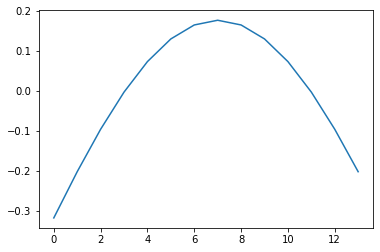

In [6]:
plt.plot(op)

In [75]:
# # np.diff(pixrange)
# for trno in [-1,-2,-5,-6,-7,-10,-11,-12,-15,-100]:
#     fig=plt.figure(figsize=(18,4))
#     plt.plot(traces[trno])
#     plt.show()


#     halflenop=int(len(op)/2)

#     trc=traces[trno]
#     # trc[trc<=3]=0
#     nlesThalf=np.sum(trc<=pixper_trc/2)
#     ngreThalf=np.sum(trc>pixper_trc/2)
#     if ngreThalf/nlesThalf<0.01:
#         trc[trc<=pixper_trc/2]=trc[trc<=pixper_trc/2]*0.01
#     print(nlesThalf,ngreThalf,ngreThalf/nlesThalf)
# #     plt.hist(trc,10)
#     trc=trc*1000
#     #     res=np.convolve(trc,op)[3:len(trc)+3]
#     res=np.convolve(trc,op)[halflenop:len(trc)+halflenop]
#     f = signal.resample(res, len(trange))
#     fig=plt.figure(figsize=(18,4))
#     plt.plot(f)
#     plt.show()

In [28]:
# plt.plot(filttrcs[-1])
# traces.shape
# plt.plot(traces[-1])
# mthresh.shape[1],traces.shape[0]

(8063, 1201)

In [73]:
# fig=plt.figure(figsize=(16,4))
# # plt.imshow((filttrcs[:100]-filttrcs[:100].mean(axis=0)).T)
# # # plt.plot(filttrcs[:100].mean(axis=0))
# # # filttrcs[:100].mean(axis=0)
# # countmeans
# mtrc=traces[trcno]
# mtrc
# # plt.plot(mtrc)
result.shape

(1201, 3968)

In [63]:
# np.unique(mtrc)
mtrc

array([0.  , 0.  , 0.  , ..., 6.  , 9.  , 0.07])

In [65]:
# def getCounts(mtrc):
counts={}
for i in np.unique(mtrc):
    counts[i]=[]
count=0
for i in range(1,len(mtrc)):
#     st=mtrc[i-1]
    if mtrc[i-1]==mtrc[i]:
        count+=1
    else:
        counts[mtrc[i-1]].append(count)
        count=0
#     return counts
counts

{0.0: [38,
  3,
  0,
  0,
  0,
  0,
  8,
  6,
  8,
  6,
  8,
  0,
  4,
  2,
  9,
  15,
  10,
  5,
  14,
  6,
  1,
  5,
  8,
  0,
  0,
  13,
  4],
 0.07000000000000028: [],
 1.0: [5,
  0,
  5,
  1,
  0,
  0,
  1,
  3,
  3,
  4,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  0,
  4,
  2,
  0,
  0],
 2.0: [0,
  0,
  0,
  0,
  2,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  2,
  5,
  3,
  0,
  0,
  7,
  1,
  0,
  4,
  9,
  5,
  5,
  4,
  4,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  4,
  0,
  2,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0],
 3.0: [0,
  0,
  0,
  2,
  0,
  1,
  1,
  1,
  0,
  2,
  7,
  0,
  0,
  1,
  0,
  0,
  0,
  2,
  2,
  0,
  0,
  0,
  2,
  0,
  0,
  6,
  1,
  0,
  2,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  3,
  2,
  9,
  1,
  2,
  5,
  0,
  7,
  0,
  4,
  4,
  8,
  2,
  9,
  9,
  0,
  4,
  2,
  0,
  1,
  12,
  0,
  0,
  12,
  3,
  0,
  0,

In [56]:
# def getOperator(mtrc):

counts=getCounts(mtrc)
countmeans={}
for k in counts  :
#     print(k,': ',np.mean(counts[k]))
    countmeans[k]=np.mean(counts[k])
hlfop_len=int(np.sum([countmeans[k] for k in countmeans]))
f=10
signal_len=2*hlfop_len/1000
print(2*hlfop_len)
dt=0.002

# mlen=peak_loc*2
mlen=2*signal_len
peak_loc=mlen/2
t = np.linspace(-peak_loc, mlen - peak_loc - dt, int(mlen / dt))

# Shift time to the correct location
# t_out = t + peak_loc  # time shift Ricker wavelet based on peak_loc

# Generate Ricker wavelet signal based on reference
op = (1 - 2 * np.pi ** 2 * f ** 2 * t ** 2) * np.exp(
    -np.pi ** 2 * f ** 2 * t ** 2)

op=op-op.mean()
#     return op

C:\Users\ArunBabu\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ArunBabu\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

In [67]:
np.mean([])

nan

In [147]:
# len(mtrc),len(hlfilter),len(hf_data)
# crude_hor_filter,useStepOp,useHorfilter=getDirections(case)
# #Horizontal filter calculation to remove horizontal lines
# twt=list(range(len(sgray)))
# lf_data,wf_data,hf_data,xmaxnormmeans=windowFilt(twt,sgray,nclip=0,window=(1,10),order=4)
# if not useStepOp:
#     op=getOperator(mtrc)
# else:
#     op=getOperatorStep(mtrc)

# mthresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
# traces=img2rawtrace(mthresh,stime,etime,ntrc)
# ntraces=100
# for ntraces in [5,10,20,50,100,200]:
    for i in range(0,len(traces),ntraces):
        start=i
        endt=i+ntraces
    #     print(start,endt)
        if endt>len(traces):
            endt=len(traces)
        parttraces=traces[i:i+ntraces]
        meantrc=np.mean(parttraces,axis=0)
        maxval=np.max(meantrc)
        meantrc[meantrc<maxval-0.05*maxval]=0
        traces[i:i+ntraces]=parttraces-meantrc
#     #     break
#     # traces=successiveDeduction(traces,ntraces=100)
#     # plt.plot(op)
#     fig=plt.figure(figsize=(16,16))
#     plt.imshow(traces.T)
# #     plt.ylim([0,400])
# #     plt.xlim([75,125])
#     plt.show()

In [160]:
# result=(np.array(traces)*1000).astype(np.float64)
# plt.plot(traces[-1])

        # todeductrace=
#         plt.plot(meantrc)

In [90]:


#Operator for smooth trace
trcno=200
mtrc=traces[trcno]

if useHorfilter:
    mtrc=mtrc*hlfilter

if not useStepOp:
    op=getOperator(mtrc)
else:
    op=getOperatorStep(mtrc)

# Filter or not and make resultant traces as float64 type
if useHorfilter:
    result=(np.array(traces)*hlfilter*1000).astype(np.float64)
else:
    result=(np.array(traces)*1000).astype(np.float64)

print(traces.shape,result.shape)
trange=np.arange(stime,etime+1,2).astype(int)
proctrcs= getOpProcTraces(result,op,trange)
filttrcs= getLowPassfilteredTraces(proctrcs)

inputdict=dict(dstpath=datafolder+file.replace('_crop.png','')+'_raw{}.sgy'.format(key),srcpath='bak_test2.sgy',
           mintime=1300,mxtime=1500,dt=1,iline=1, xline=169, offset=0)

status=saveAsSegy(filttrcs.T,inputdict=inputdict,delrt=2)
if status:    
    print('Done export..',inputdict['dstpath'])
else:
    print('Export incomplete..')
fig=plt.figure(figsize=(16,16))
#     plt.imshow(filttrcs.T[:800,-800:])
plt.imshow(filttrcs.T)
plt.show()

(3011, 3007, 3007)

3007


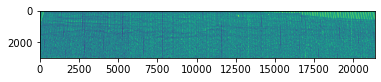

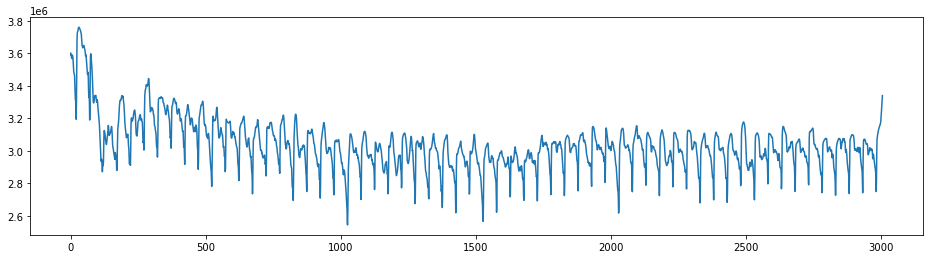

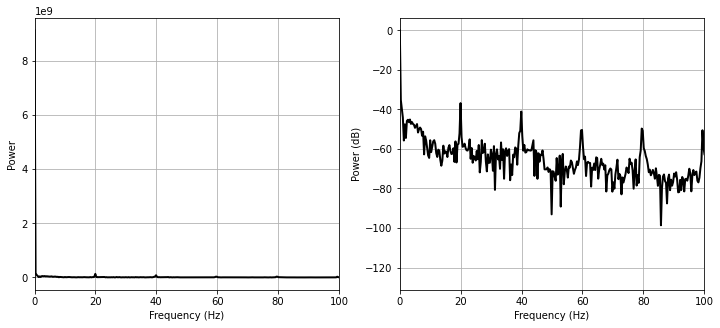

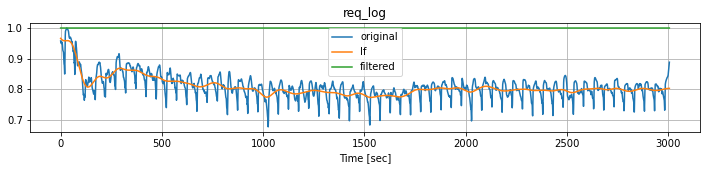

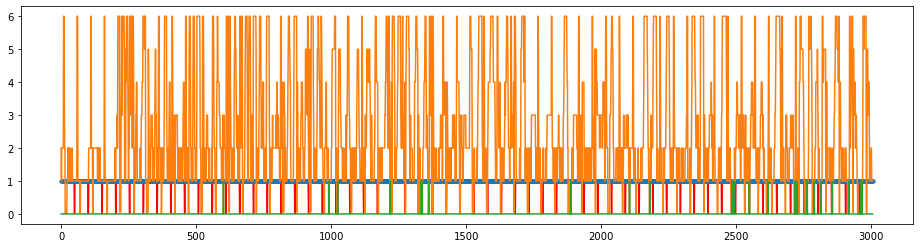

In [59]:
#key insights

plt.imshow(gray)
# thresh[:10,:100]
sgray=gray.sum(axis=1)
print(len(sgray))
fig=plt.figure(figsize=(16,4))
plt.plot(sgray)
freq, SIGNAL =ampspec(sgray,1,smooth=False)
plot_ampspec(freq, SIGNAL,name=None,img_fpath=None)


myplot(twt,[sgray/xmaxnormmeans,lf_data+wf_data,hf_data],['original','lf','filtered','hfdata'],mtitle='req_log')
# myplot(twt,[sgray/xmaxnormmeans,(lf_data+wf_data)],['original','filtered','hfdata'],mtitle='req_log')
fig=plt.figure(figsize=(16,4))
plt.plot(hlfilter,'-r')

plt.plot(hlfilter_raw,'.')


# plt.imshow( np.array(traces).T[:40,:20])
otrc=traces[2928]
otrc=otrc*fullfilter
# plt.figure(figsize=(16,4))
# plt.plot(otrc)
mtrc=otrc.copy()
plt.plot(mtrc)
mtrc[mtrc>0]=10
dtrc=np.diff(mtrc.astype(float))
dtrc[dtrc>0]=1
dtrc[dtrc<0]=0
round(len(dtrc)/dtrc.sum())
plt.plot(dtrc)

# len(trange),pixper_trc
# traces.min()

# plt.figure(figsize=(16,4))
# plt.plot(otrc,'r')
# plt.plot(otrc*fullfilter,'g')

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(proctrcs[trcno]),len(proctrcs[trcno]),len(proctrcs[trcno])
plt.show()
# fromsample=5
# plt.plot(t[:len(t)-fromsample], , 'g-', linewidth=2, label='filtered data')
plt.figure(figsize=(16,4))
plt.plot(proctrcs[trcno]),len(proctrcs[trcno]),len(proctrcs[trcno])
plt.plot(filttrcs[trcno]),len(filttrcs[trcno]),len(filttrcs[trcno])